[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/)


# Capstone Project: Mask Wearing Detector
---


## Table of Contents

1. Preprocessing
2. Modelling
---

In [1]:
#import libraries
from google.colab import drive
import os
import cv2
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img,
)
import keras

In [2]:
#check for tensorflow version and GPU availability
print("Tensorflow Version: {}".format(tf.__version__))
print(tf.test.gpu_device_name())
print(
    "Num GPUs Available: ",
    len(tf.config.experimental.list_physical_devices("GPU")),
)

Tensorflow Version: 2.7.0
/device:GPU:0
Num GPUs Available:  1


In [3]:
#import data
!git clone https://github.com/siowcm/capstone.git
print('git clone completed')

Cloning into 'capstone'...
remote: Enumerating objects: 5805, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 5805 (delta 3), reused 15 (delta 3), pack-reused 5790
Receiving objects: 100% (5805/5805), 418.35 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (851/851), done.
Checking out files: 100% (5788/5788), done.
git clone completed


In [4]:
# define path
IMGS_PATH = "capstone/input_data/images/"
ANNOT_PATH = "capstone/input_data/annotations/"
CROPPED_PATH = "capstone/output_data/cropped_images/"
CSV_PATH = "capstone/output_data/csv/"

In [5]:
#import csv as dataframe
df = pd.read_csv(CSV_PATH+'mask.csv')
df.head()

,xmin,ymin,xmax,ymax,label,width,height,images,annotation,cropped_images
0,185,100,226,144,with_mask,512,366,maksssksksss0.png,maksssksksss0.xml,maksssksksss0-0.png
1,79,105,109,142,without_mask,512,366,maksssksksss0.png,maksssksksss0.xml,maksssksksss0-1.png
2,325,90,360,141,without_mask,512,366,maksssksksss0.png,maksssksksss0.xml,maksssksksss0-2.png
3,369,70,398,99,with_mask,400,156,maksssksksss1.png,maksssksksss1.xml,maksssksksss1-3.png
4,21,73,44,93,with_mask,400,156,maksssksksss1.png,maksssksksss1.xml,maksssksksss1-4.png


In [8]:
# create training and testing data
df_train, df_test = train_test_split(df, train_size=0.8, random_state=42, stratify=df['label'])

In [9]:
# check the shape of training and testing data
print(f'Shape of training df: {df_train.shape}')
print(f'Shape of testing df: {df_test.shape}')

Shape of training df: (3257, 10)
Shape of testing df: (815, 10)


In [10]:
# train_image_generator = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     validation_split = 0.2
# )

In [11]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.2
)

In [12]:
train_generator = train_image_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = CROPPED_PATH,
    x_col = 'cropped_images',
    y_col = 'label',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (24,24)#default tuple of integers (height, width), default: (256, 256). The dimensions to which all images found will be resized.
)

valid_generator = train_image_generator.flow_from_dataframe(
    dataframe = df_train,
    directory = CROPPED_PATH,
    x_col = 'cropped_images',
    y_col = 'label',
    subset = 'validation',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (24,24) #image_target_size
)

Found 2606 validated image filenames belonging to 3 classes.
Found 651 validated image filenames belonging to 3 classes.


In [13]:
test_image_generator = ImageDataGenerator(
    rescale=1./255,
)

test_generator = train_image_generator.flow_from_dataframe(
    dataframe = df_test,
    directory = CROPPED_PATH,
    x_col = 'cropped_images',
    y_col = 'label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (24,24) #image_target_size
)

Found 815 validated image filenames belonging to 3 classes.


In [14]:
model_1 = keras.models.Sequential([
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu', 
                        input_shape = (24, 24, 3)),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 3, activation = 'softmax')
])

In [15]:
model_1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy', keras.metrics.Recall()]
)

history_1 = model_1.fit(
    train_generator,
    epochs = 10,
    steps_per_epoch = len(train_generator),
    validation_data = valid_generator, 
    validation_steps = len(valid_generator)
)

Epoch 1/10
82/82 [==============================] - 12s 30ms/step - loss: 0.6311 - accuracy: 0.7744 - recall: 0.6650 - val_loss: 0.5698 - val_accuracy: 0.7819 - val_recall: 0.7680
Epoch 2/10
82/82 [==============================] - 2s 23ms/step - loss: 0.4304 - accuracy: 0.7989 - recall: 0.7851 - val_loss: 0.3479 - val_accuracy: 0.8111 - val_recall: 0.7757
Epoch 3/10
82/82 [==============================] - 2s 22ms/step - loss: 0.2751 - accuracy: 0.9060 - recall: 0.8830 - val_loss: 0.2291 - val_accuracy: 0.9324 - val_recall: 0.9309
Epoch 4/10
82/82 [==============================] - 2s 23ms/step - loss: 0.2219 - accuracy: 0.9279 - recall: 0.9236 - val_loss: 0.2025 - val_accuracy: 0.9386 - val_recall: 0.9370
Epoch 5/10
82/82 [==============================] - 2s 23ms/step - loss: 0.2121 - accuracy: 0.9336 - recall: 0.9290 - val_loss: 0.1952 - val_accuracy: 0.9370 - val_recall: 0.9339
Epoch 6/10
82/82 [==============================] - 2s 23ms/step - loss: 0.2046 - accuracy: 0.9325 - rec

In [16]:
result_1 = pd.DataFrame(history_1.history)
result_1

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
0,0.631125,0.774367,0.665004,0.569828,0.781874,0.768049
1,0.430393,0.798926,0.785111,0.347863,0.811060,0.775730
2,0.275146,0.905986,0.882962,0.229116,0.932412,0.930876
3,0.221913,0.927859,0.923638,0.202545,0.938556,0.937020
4,0.212075,0.933615,0.929010,0.195238,0.937020,0.933948
5,0.204578,0.932464,0.927859,0.195710,0.933948,0.932412
6,0.200439,0.932080,0.929010,0.183198,0.943164,0.941628
7,0.194716,0.935917,0.931696,0.179705,0.947773,0.946237
8,0.187563,0.940522,0.936301,0.200737,0.930876,0.927803
9,0.183349,0.939371,0.936301,0.177957,0.946237,0.944700


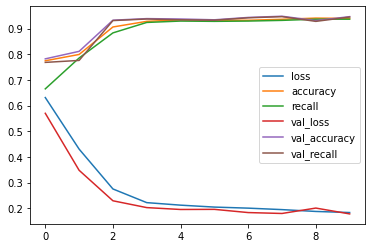

In [17]:
result_1.plot()

In [18]:
def plot_line(result, ax, col, title, train_column, valid_column):
    # Line Plot of Model Performance
    ax[col].plot(result[train_column])
    ax[col].plot(result[valid_column])
    
    # Title and Legend
    ax[col].set_title(title, fontweight = 'bold')
    ax[col].legend(['Train', 'Validation'])
    
def plot_result(result, train_recall, valid_recall):
    # Create a 1x3 Grid and Set Main Title
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (17, 8))
    fig.suptitle('Model Performance', fontsize = 20, fontweight = 'bold')
    
    # Visualization of Accuracy, Recall, and Loss
    plot_line(result, ax, 0, 'Accuracy', 'accuracy', 'val_accuracy')
    plot_line(result, ax, 1, 'Recall', train_recall, valid_recall)
    plot_line(result, ax, 2, 'Loss', 'loss', 'val_loss')
    plt.show()

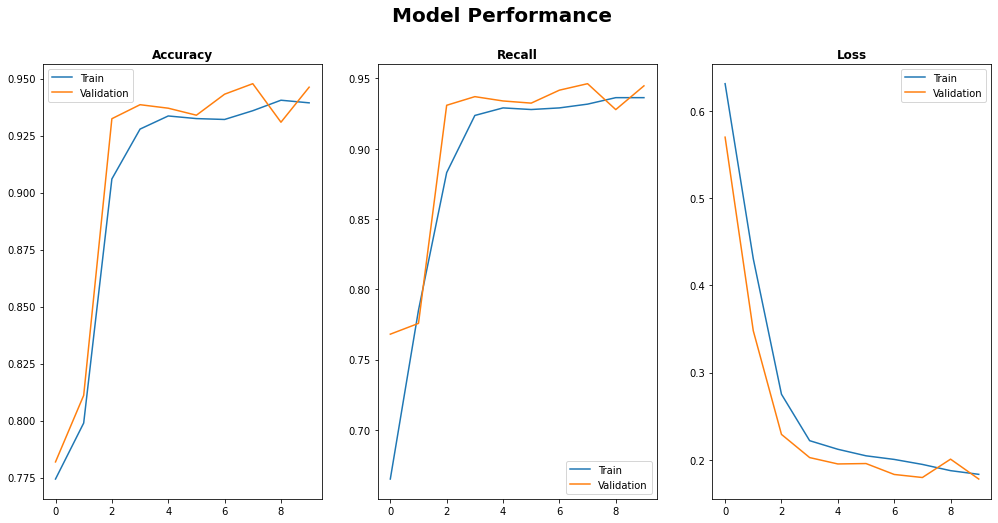

In [19]:
plot_result(result_1, 'recall', 'val_recall')

In [20]:
model_2 = keras.models.Sequential([
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu', input_shape = input_shape),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    keras.layers.MaxPool2D(pool_size = 2, padding = 'valid'),
    keras.layers.Flatten(),
    keras.layers.Dense(units = len(classes), activation = 'softmax')
])

NameError: ignored

In [ ]:
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(),
                metrics = ['accuracy', keras.metrics.Recall()])

callbacks = [keras.callbacks.EarlyStopping()]

history_2 = model_2.fit(train_generator, epochs = 100, steps_per_epoch = len(train_generator), 
                        validation_data = valid_generator, validation_steps = len(valid_generator),
                        callbacks = callbacks)

In [ ]:
result_2 = pd.DataFrame(history_2.history)
result_2

In [ ]:
result_2.plot()

In [ ]:
plot_result(result_2, 'recall_1', 'val_recall_1')

In [ ]:
# model_1.save('/content/gdrive/MyDrive/capstone_data/model')

In [ ]:
model_1.summary()

# CHECK categorical_crossentropy
 

In [ ]:
input_shape = 

In [ ]:
train_df

In [ ]:
test_df